# Transfer Learning to Detect Objects

Today you are a Machine Learning Engineer on the Perception team at Apple that works on iphone cameras. Your goal is to do **transfer learning** from an existing object detector model to automatically detect pets (dogs in this example). 

The idea is that you have access to a model that you or one of your colleagues has already trained on a large and diverse set of images, but that is not very specific for your task (dog detection). We'll do transfer learning by fine-tuning this existing model on a small dataset of dog images. 

The objective of this assignment is to show you the mechanics of using a pretrained TensorFlow model, doing some fine tuning, and interpreting the outputs of this detection model.

This assignment is based on the official TF tutorial here: https://colab.research.google.com/github/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

## Task 1: Setup

1. If you're running in Colab, mount the drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Download the [tensorflow models repository](https://github.com/tensorflow/models) so we can make use of a model that has already been trained.

In [ ]:
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3311, done.
remote: Counting objects: 100% (3311/3311), done.
remote: Compressing objects: 100% (2733/2733), done.
remote: Total 3311 (delta 877), reused 1396 (delta 529), pack-reused 0
Receiving objects: 100% (3311/3311), 34.29 MiB | 32.63 MiB/s, done.
Resolving deltas: 100% (877/877), done.


3. Install dependencies of the pretrained models.

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1685426 sha256=7a4bdb1a0f779ca2ae2cd64ac163076c32b3aeb5c9ebce47853633dddf9d3a2e
  Stored in directory: /tmp/pip-ephem-wheel-cache-zckh7rbu/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=9aadc39422ed078d7472303a2c68fcc9009919cd781a3553c7ce6b438ab9cdfa
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78544 sha256=7e13521a0cc53513b6bd777df4f95e89a241020237f2cede115780f16cde0aa6
  Stored in directory: /root/.cache/pip/wheels/a4/61/fd/c57e374e580aa78a45ed78d5859b3a44436af17e22ca53284f
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=44010 sha256=f166ba9575d4519d4325efea6498649adc0d4ca865574b7d73

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
gym 0.17.3 requires cloudpickle<1.7.0,>=1.2.0, but you have cloudpickle 2.0.0 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


## Task 2: Load in and examine the training data

1. Download the images and update the link below to where you have the files located. How many images are there?

In [ ]:
import os

dog_dataset_path = '/content/drive/My Drive/FourthBrain/Assignments/Week_6/dog_dataset/'
train_image_dir = os.path.join(dog_dataset_path, 'train/images/')
image_names = os.listdir(train_image_dir)

print('Number of images: ', len(image_names))

Number of images:  10


2. The function `load_image_into_numpy_array()` is a helper function for loading in images. Use it load in the training images and save them in a list `train_images_np`.

In [ ]:
import tensorflow as tf
from PIL import Image
from six import BytesIO
import numpy as np

def load_image_into_numpy_array(path):
    """
    Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: a file path.

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
train_images_np = []

for image in image_names:
  train_images_np.append(load_image_into_numpy_array(train_image_dir+image))

len(train_images_np)

10

3. Use the following code to draw the images. Take a look at the images. The task will be to detect where the dog is in the image.

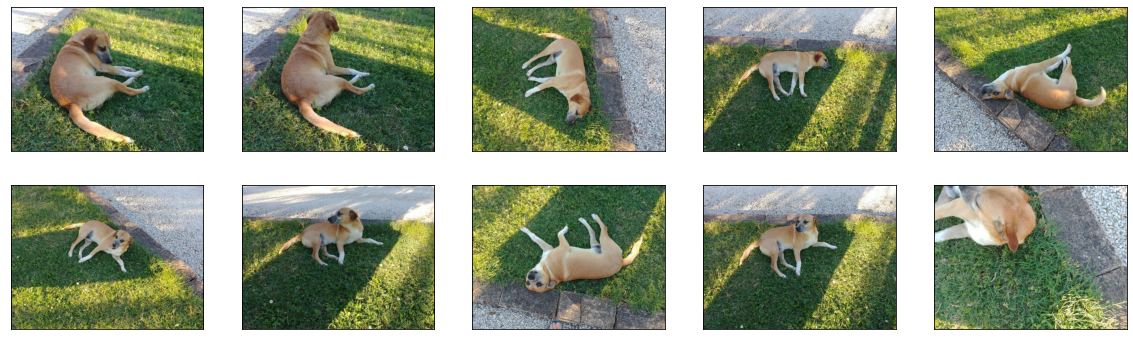

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
for idx, train_image_np in enumerate(train_images_np):
    ax = plt.subplot(2, len(train_images_np) / 2, idx + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(train_image_np)

4. What is the shape of each image (width, height and number of color channels)?

In [ ]:
for train_image_np in enumerate(train_images_np):
  print(train_image_np[1].shape)

(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)
(480, 640, 3)


The object detection model we'll use spits out bounding boxes where it thinks there **might** be an object. For each bounding box, it also makes a prediction of which class the object is from, and there is an associated "score", or confidence, of this prediction. 

The format for specifying bounding boxes that is found in our training data, and the model outputs, is [ymin,xmin,ymax,xmax], where y is the vertical position and x is the horizontal position. (a bounding box of [0.1, 0.15, 0.8, 0.9] means one whose lower left corner is at position (0.1, 0.15) and whose upper right corner is at (0.8, 0.9))

These values are of course agnostic to the size of the image, if you wanted to convert them to pixels you would multiply by the width or height of the image (in pixels). 

Luckily, we have a function from the object detection visualization utilities, ```visualize_boxes_and_labels_on_image_array```, that will help us display the bounding boxes overlaid on an image, and we'll see how to use it below. 

First, though, let's read some annotations (including the ground-truth bounding boxes) for these training images.

5. Use the `read_content()` function as given to read in all the annotations and save them in a list `gt_boxes`.

In [ ]:
import xml.etree.ElementTree as ET

def read_content(xml_file: str, w, h):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):
        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None
        ymin = int(boxes.find("bndbox/ymin").text) / h
        xmin = int(boxes.find("bndbox/xmin").text) / w
        ymax = int(boxes.find("bndbox/ymax").text) / h
        xmax = int(boxes.find("bndbox/xmax").text) / w

        list_with_single_boxes = [ymin, xmin, ymax, xmax]
        list_with_all_boxes.append(list_with_single_boxes)

    #return filename, list_with_all_boxes
    return list_with_all_boxes

In [ ]:
train_ann_dir = os.path.join(dog_dataset_path, 'train/annotations/')
gt_boxes = []

train_ann_dir_files = os.listdir(train_ann_dir)

for file in train_ann_dir_files:
    gt_boxes.append(np.asarray(read_content(train_ann_dir + file,640,480)))
len(gt_boxes)

10

6. Run the following code to create the target tensors for our model to use in training.

In [ ]:
dog_class_id = 1
num_classes = 1

category_index = {dog_class_id: {'id': dog_class_id, 'name': 'dog'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for train_image_np, gt_box_np in zip(train_images_np, gt_boxes):
    train_image_tensors.append(
        tf.expand_dims(
            tf.convert_to_tensor(train_image_np, dtype=tf.float32),
            axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=np.array(gt_box_np).shape[0], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(
        tf.one_hot(zero_indexed_groundtruth_classes, num_classes))

7. The following code uses the `visualize_boxes_and_labels_on_image_array()` function to plot these bounding boxes on their respective images. Look at the images which show the dogs corrected identified in each image.

Bounding box for image 0:  [[0.30833333 0.18125    0.65208333 0.66875   ]]
Bounding box for image 1:  [[0.25208333 0.2359375  0.72083333 0.9015625 ]]
Bounding box for image 2:  [[0.20416667 0.246875   0.75       0.8859375 ]]
Bounding box for image 3:  [[0.24791667 0.25625    0.60833333 0.63125   ]]
Bounding box for image 4:  [[0.16041667 0.1921875  0.55833333 0.7375    ]]


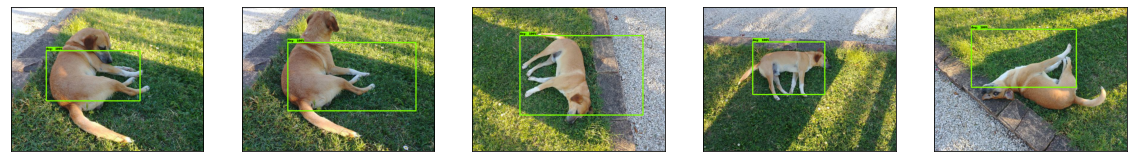

In [ ]:
from object_detection.utils import visualization_utils as viz_utils

dummy_scores = np.array([1.0], dtype=np.float32)
plt.figure(figsize=(20, 3))
for idx in range(5):
    ax = plt.subplot(1, 5, idx + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    temp_img_copy = np.copy(train_images_np[idx])
    gt_boxes_array = np.asarray(gt_boxes)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        temp_img_copy,
        gt_boxes[idx],
        np.ones(shape=[gt_boxes_array[idx].shape[0]], dtype=np.int32),
        dummy_scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.0)
    plt.imshow(temp_img_copy)
    print(f'Bounding box for image {idx}: ', gt_boxes[idx])

8. Follow the same process to load in the test images and save them as `test_images_np`.

In [ ]:
test_images_np = []

test_image_dir = os.path.join(dog_dataset_path, 'test/images/')

t_image_names = os.listdir(test_image_dir)
t_num = len(t_image_names)
for i in t_image_names:
    image_path = os.path.join(test_image_dir, i)
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))

9. Follow the same process as above to load in the bounding box annotations for the test images. Save them as `t_gt_boxes`.

In [ ]:
t_gt_boxes = []

test_ann_dir = os.path.join(dog_dataset_path, 'test/annotations/xmls/')

test_ann_dir_files = os.listdir(test_ann_dir)

for test_file in test_ann_dir_files:
  t_gt_boxes.append(read_content(test_ann_dir + test_file, 640, 480))

10. How many test images are there?

In [ ]:
len(t_image_names)

40

## Task 3: Load and Run Object Detection Model

1. Download the checkpoint and put it into `models/research/object_detection/test_data/`.

    This model is an SSD object detetion with Resnet50 backbone with feature pyramid network. You can choose other models here, such as YOLO, feasterRCNN, etc, from the options.

In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/


--2022-03-30 06:13:54--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.134.128, 2607:f8b0:400c:c00::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.134.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   220MB/s    in 1.1s    

2022-03-30 06:13:55 (220 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



2. Run the code below to load in the pretrained model.

    One reason it is fairly complex is that the pretrained model requires backward compatibility with TensorFlow 1.0 and because there is some added complexity for managing all the different pretrained models in this particular repository. For some documentation on the simpler and more clean semantics of saving and loading model checkpoints in TensorFlow 2.0 see [this documentation](https://www.tensorflow.org/tutorials/keras/save_and_load?authuser=2)

In [ ]:
from object_detection.utils import config_util
from object_detection.builders import model_builder

tf.keras.backend.clear_session()

num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)

3. Use the following code to make some predictions *before* fine-tuning. The model by default will generate 100 possible objects, each with associated scores and predicted classes.

    We utilize the `detect()` function, which wraps the preprocessing, prediction, and postprocessing step with the `tf.function` dectorator so that this computation will enjoy faster performance (see [this tutorial](https://www.tensorflow.org/guide/function) for more context).

In [ ]:
@tf.function
def detect(input_tensor):
    """Run detection on an input image.

    Args:
      input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
        Note that height and width can be anything since the image will be
        immediately resized according to the needs of the model within this
        function.

    Returns:
      A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
        and `detection_scores`).
    """
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

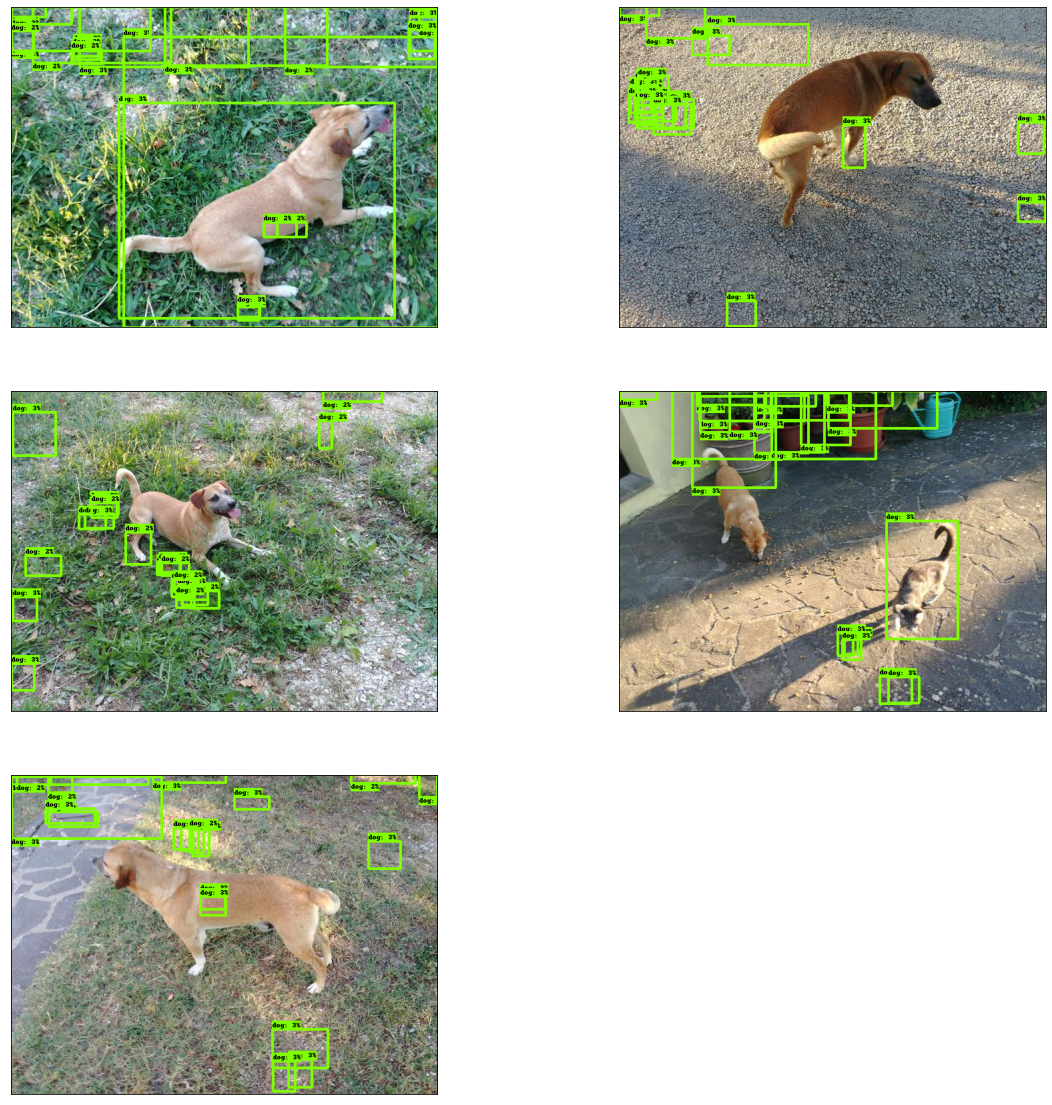

In [ ]:
pre_ft_bb_preds = []
pre_ft_scores_preds = []
pre_ft_classes_preds = []
label_id_offset = 1
plt.figure(figsize=(20, 20))
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    pre_ft_bb_preds.append(detections['detection_boxes'][0].numpy())
    pre_ft_scores_preds.append(detections['detection_scores'][0].numpy())
    pre_ft_classes_preds.append(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)
    if i < 5:
        ax = plt.subplot(3, 2, i + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        temp_img_copy = np.copy(test_images_np[i][0])
        viz_utils.visualize_boxes_and_labels_on_image_array(
            temp_img_copy,
            pre_ft_bb_preds[-1],
            pre_ft_classes_preds[-1],
            pre_ft_scores_preds[-1],
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh=0.0
        )
        plt.imshow(temp_img_copy)

4. You can see that it makes some bad predictions (though the correct prediction is one of the possibilities). Let's just display its most confident prediction.

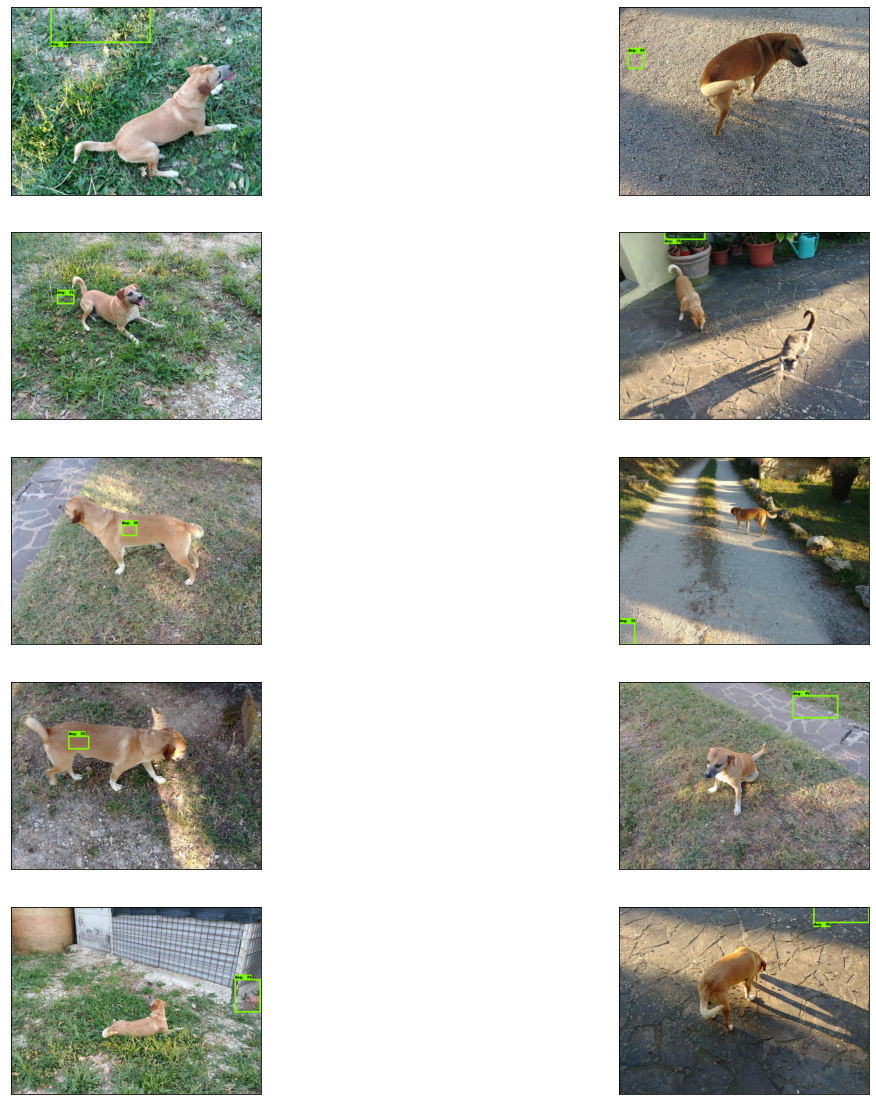

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(5, 2, i + 1)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    most_confident_bb = np.argmax(pre_ft_scores_preds[i])
    temp_img_copy = np.copy(test_images_np[i][0])
    viz_utils.visualize_boxes_and_labels_on_image_array(
        temp_img_copy,
        pre_ft_bb_preds[i][most_confident_bb][None, :],
        np.array([pre_ft_classes_preds[i][most_confident_bb]]),
        np.array([pre_ft_scores_preds[i][most_confident_bb]]),
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.0
    )
    plt.imshow(temp_img_copy)

## Task 4: Implement Computation of Intersection Over Union metric

1. The [Intersection over Union](https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/) is one way to measure how *good* a bounding box prediction is.

   Complete the `bounding_box_iou()` function below. You will need to complete these steps in the code:
   
   - Determine the coodinates of the intersection rectangle.
   - Compute the area of the intersection rectangle.
   - Compute the area of both the prediction and ground-truth rectangles.
   - Compute and return the intersection over union by taking the intersection area and dividing it by the sum of the prediction and ground-truth areas minus the intersection area.

In [ ]:
def bounding_box_iou(boxA, boxB):
  """
  Computes the Intersection over Union for two bounding boxes

  The boxes should have format (ymin, xmin, ymax, xmax)
  """
  xA = max(boxA[0][0],boxB[0][0])
  yA = max(boxA[0][1],boxB[0][1])
  xB = min(boxA[0][2],boxB[0][2])
  yB = min(boxA[0][3],boxB[0][3])

  iArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

  boxAArea = (boxA[0][2] - boxA[0][0] + 1) * (boxA[0][3] - boxA[0][1] + 1)
  boxBArea = (boxB[0][2] - boxB[0][0] + 1) * (boxB[0][3] - boxB[0][1] + 1)

  iou = iArea / float(boxAArea + boxBArea - iArea)

  return iou

2. Use the `compute_best_iou_and_score()` function to find mean IoU and scores of the test images.

    Remember the test images are stored in `t_gt_boxes`, the predicted bounding boxes are stored in `pre_ft_bb_preds` and the prediction scores per bounding box are stored in `pre_ft_scores_preds`.

In [ ]:
def compute_best_iou_and_score(gt_bounding_box, predicted_bounding_boxes, prediction_scores_per_bb):
    indv_ious = []
    for bbox_idx in range(len(predicted_bounding_boxes)):
        indv_ious.append(bounding_box_iou(gt_bounding_box, predicted_bounding_boxes[bbox_idx]))
    if len(indv_ious) == 0:
        return 0, 0
    best_bounding_box = np.argmax(indv_ious)
    return indv_ious[best_bounding_box], prediction_scores_per_bb[best_bounding_box]

In [ ]:
indv_ious_b, prediction_scores_per_bb_b = compute_best_iou_and_score(t_gt_boxes, pre_ft_bb_preds, pre_ft_scores_preds)
print(indv_ious_b)
print(prediction_scores_per_bb_b)

## Task 5: Fine-tune the model

1. The variables that we can train are located in the `.trainable_variables` attribute of the model. How many variables are there?

In [ ]:
len(detection_model.trainable_variables)

269

2. Print the names of all the trainable variables.

In [ ]:
for train_var in detection_model.trainable_variables:    
    print(train_var.name)

WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead/BoxPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/kernel:0
WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead/ClassPredictor/bias:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_0/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/kernel:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/gamma:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_1/BatchNorm/feature_0/beta:0
WeightSharedConvolutionalBoxPredictor/BoxPredictionTower/conv2d_2/kernel:0
WeightSharedConvolutional

We're going to fine tune the `WeightSharedConvolutionalBoxPredictor` layer only. Don't worry about why specifically this layer for the purposes of this tutorial. When you fine tune your own models, picking which parts of it to fine tune are a combination of the inductive bias you impose, and the result of hyperparameter optimization.

3. Complete the `get_model_train_step_function()` function.

    * Use the model's `.predict()` method to generate predictions and save as `prediction_dict`.
    * Use the model's `.loss()` method and save as `losses_dict`.
    * Make `total_loss` equal to the sum of `localization_loss` and `classification_loss` from the losses dictionary.

In [ ]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    """Get a tf.function for training step."""

    # Use tf.function for a bit of speed.
    # Comment out the tf.function decorator if you want the inside of the
    # function to run eagerly.
    @tf.function
    def train_step_fn(image_tensors, groundtruth_boxes_list, groundtruth_classes_list):
        """A single training iteration.
        Args:
          image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
            Note that the height and width can vary across images, as they are
            reshaped within this function to be 640x640.
          groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
            tf.float32 representing groundtruth boxes for each image in the batch.
          groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
            with type tf.float32 representing groundtruth classes for each image in
            the batch.

        Returns:
          A scalar tensor representing the total loss for the input batch.
        """
        
        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

4. Set the tuning parameters. We give reasonable values, but feel free to adjust them and see how it affects the convergence of the model.

In [ ]:
batch_size = 10
learning_rate = 0.01
num_batches = 100

5. Complete the following code by completing the `optimizer` and `train_step_fn`.

    * Instantiate an SGD optimizer using the learning rate, and a momentum of 0.9 and save it as `optimizer`.
    * Call the `get_model_train_step_function()` function to create `train_step_fn`.

In [ ]:
tf.keras.backend.set_learning_phase(True)

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(detection_model, optimizer,to_fine_tune )

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


6. Run the following code to do the fine-tuning.

In [ ]:
import random

for idx in range(num_batches):
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]

    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]

    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if idx % 10 == 0:
        print('batch ' + str(idx) + ' of ' + str(num_batches) + ', loss=' +  str(total_loss.numpy()), flush=True)

batch 0 of 100, loss=1.7641871
batch 10 of 100, loss=3.264394
batch 20 of 100, loss=1.3905442
batch 30 of 100, loss=0.76632744
batch 40 of 100, loss=0.53987515
batch 50 of 100, loss=0.33119577
batch 60 of 100, loss=0.20486224
batch 70 of 100, loss=0.14953655
batch 80 of 100, loss=0.11567372
batch 90 of 100, loss=0.093639344


7. Now look at the bounding boxes for our fine-tuned model.

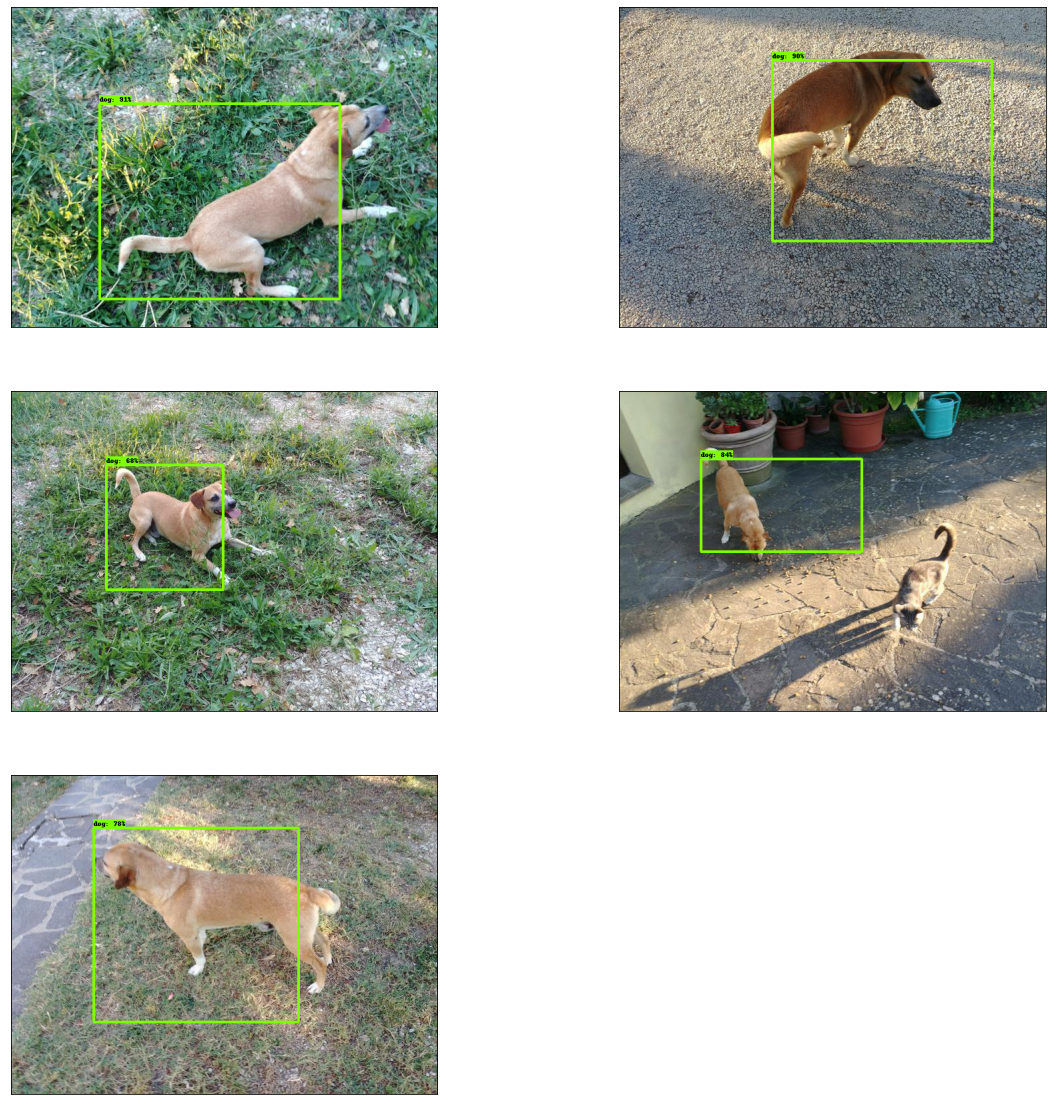

In [ ]:
post_ft_bb_preds = []
post_ft_scores_preds = []
post_ft_classes_preds = []
plt.figure(figsize=(20, 20))
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    post_ft_bb_preds.append(detections['detection_boxes'][0].numpy())
    post_ft_scores_preds.append(detections['detection_scores'][0].numpy())
    post_ft_classes_preds.append(detections['detection_classes'][0].numpy().astype(np.uint32) + label_id_offset)
    if i < 5:
        ax = plt.subplot(3, 2, i + 1)
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        temp_img_copy = np.copy(test_images_np[i][0])
        most_confident_bb = np.argmax(post_ft_scores_preds[i])
        viz_utils.visualize_boxes_and_labels_on_image_array(
            temp_img_copy,
            post_ft_bb_preds[i][most_confident_bb][None, :],
            np.array([post_ft_classes_preds[i][most_confident_bb]]),
            np.array([post_ft_scores_preds[i][most_confident_bb]]),
            category_index,
            use_normalized_coordinates=True,
            min_score_thresh=0.0
        )
        plt.imshow(temp_img_copy)

8. Compute the mean IoU and scores for the fine_tuned model following the same steps as in task 4. The performance should be much better than the original model.

In [ ]:
indv_ious_b, prediction_scores_per_bb_b = compute_best_iou_and_score(t_gt_boxes, post_ft_bb_preds, post_ft_scores_preds)
print(indv_ious_b)
print(prediction_scores_per_bb_b)